In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
# load train and test data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head(5)

id                              belongs_to_collection    budget  \
0   1  [{'id': 313576, 'name': 'Hot Tub Time Machine ...  14000000   
1   2  [{'id': 107674, 'name': 'The Princess Diaries ...  40000000   
2   3                                                NaN   3300000   
3   4                                                NaN   1200000   
4   5                                                NaN         0   

                                              genres  \
0                     [{'id': 35, 'name': 'Comedy'}]   
1  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
2                      [{'id': 18, 'name': 'Drama'}]   
3  [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...   
4  [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...   

                            homepage    imdb_id original_language  \
0                                NaN  tt2637294                en   
1                                NaN  tt0368933                en   
2  http://sonyclassics.com/whiplash/  tt2582802                en   
3         http://kahaanithefilm.com/  tt1821480                hi   
4                                NaN  tt1380152                ko   

                             original_title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   
2                                  Whiplash   
3                                   Kahaani   
4                                      마린보이   

                                            overview  popularity  ...  \
0  When Lou, who has become the "father of the In...    6.575393  ...   
1  Mia Thermopolis is now a college graduate and ...    8.248895  ...   
2  Under the direction of a ruthless instructor, ...   64.299990  ...   
3  Vidya Bagchi (Vidya Balan) arrives in Kolkata ...    3.174936  ...   
4  Marine Boy is the story of a former national s...    1.148070  ...   

  release_date runtime                                   spoken_languages  \
0      2/20/15    93.0           [{'iso_639_1': 'en', 'name': 'English'}]   
1       8/6/04   113.0           [{'iso_639_1': 'en', 'name': 'English'}]   
2     10/10/14   105.0           [{'iso_639_1': 'en', 'name': 'English'}]   
3       3/9/12   122.0  [{'iso_639_1': 'en', 'name': 'English'}, {'iso...   
4       2/5/09   118.0           [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]   

     status                                            tagline  \
0  Released  The Laws of Space and Time are About to be Vio...   
1  Released  It can take a lifetime to find true love; she'...   
2  Released    The road to greatness can take you to the edge.   
3  Released                                                NaN   
4  Released                                                NaN   

                                      title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   
2                                  Whiplash   
3                                   Kahaani   
4                                Marine Boy   

                                            Keywords  \
0  [{'id': 4379, 'name': 'time travel'}, {'id': 9...   
1  [{'id': 2505, 'name': 'coronation'}, {'id': 42...   
2  [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...   
3  [{'id': 10092, 'name': 'mystery'}, {'id': 1054...   
4                                                NaN   

                                                cast  \
0  [{'cast_id': 4, 'character': 'Lou', 'credit_id...   
1  [{'cast_id': 1, 'character': 'Mia Thermopolis'...   
2  [{'cast_id': 5, 'character': 'Andrew Neimann',...   
3  [{'cast_id': 1, 'character': 'Vidya Bagchi', '...   
4  [{'cast_id': 3, 'character': 'Chun-soo', 'cred...   

                                                crew   revenue  
0  [{'credit_id': '59ac067c92514107af02c8c8', 'de...  12314651  
1  [{'credit_id': '52fe43fe9251416c7502563d', 'de...  95149435  
2  [{'credit_id': '54d5356ec3a3683ba0000039', 'de...  13092000  
3  [{'credit_id': '52fe48779251

In [3]:
# train shape
train.shape

(3000, 23)

In [4]:
# test shape
test.shape

(4398, 22)

In [5]:
# check Null
train.isna().values.sum()

5601

In [6]:
# list all column 
train.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')

In [7]:
# Get Name From Data
def get_name(data):
    try:
        x = eval(data) 
        return x[0]['name']
    except:
        return ''

# Get length of data
def get_len(data):
    try:
        x = eval(data)
        return len(x)
    except:
        return 0

# Get all data by column
def all_data(data, key = 'name'):
    try:
        x = eval(data)
        return ' '.join(sorted([i[key] for i in x]))
    except:
        return 

# all data of column convert into list 
def make_list(data, key = 'name'):
    try:
        data = eval(data)
        return [i[key] for i in data]
    except: 
        return []

# applying one hot encoding for multiple data
def apply_encode(data, name):
    try:
        if name in data:
            return 1
        else:
            return 0
    except:
        return

# Get Gender Type [0,1,2]  
def get_gender(data,index):
    try:
        data = eval(str(data))
        count = 0
        for i in data:
            if i['gender'] == index:
                count += 1
        return count
    except:
        return 0

# Change feature name to singular verb
def singular_verb(feature_name):
    if feature_name == 'production_countries':
        return 'production_country'
    elif feature_name == 'production_companies':
        return 'production_company'
    elif feature_name == 'spoken_languages':
        return 'spoken_language'
    elif feature_name == 'Keywords':
        return 'Keyword'
    else:
        return feature_name

# Fixes dates which are in 20xx
def fix_date(x):
    year = x.split('/')[2]
    if int(year) <= 19:
        return x[:-2] + '20' + year
    else:
        return x[:-2] + '19' + year

# creating features based on dates
def process_date(df):
    date_parts = ["year", "weekday", "month", 'weekofyear', 'day', 'quarter']
    for part in date_parts:
        part_col = 'release_date' + "_" + part
        df[part_col] = getattr(df['release_date'].dt, part).astype(int)
    return df

#...............................
#
# Remove same data
# def unique_list(data):
#    if data:
#        k=set()
#        for i in data:
#            for m in i:
#                k.add(m)
#        return list(k)
#
# old count word function
# count = 0
# def count_word(data, name):
#    try:
#        if name in data:
#            global count
#            count += 1
#            return name
#    except:
#        return
#
# old comman word finder function
# def comman_word(feature, all_word, fetch = 25):
#    make_count = []
#    for name in all_word:
#        global count
#        count = 0
#       not_to_print = feature.apply(lambda x:count_word(x, name))
#        make_count.append([name, count])
#        print([name, count])
#    k = sorted(make_count, key = lambda x: x[1])[::-1]
#   return np.array(k)[:fetch,0]
#
#.................................

In [8]:
# train missing values
train['runtime'].fillna(0, inplace=True)
train['status'].fillna('Released', inplace=True)
train['release_date'].fillna(train['release_date'].mode()[0], inplace=True)

# test missing values
test['runtime'].fillna(0, inplace=True)
test['status'].fillna('Released', inplace=True)
test['release_date'].fillna(test['release_date'].mode()[0], inplace=True)

In [9]:
# train data cleaning
train['collection_name'] = train['belongs_to_collection'].apply(get_name)
train['num_of_collection'] = train['belongs_to_collection'].apply(get_len)
train['num_of_genres'] = train['genres'].apply(get_len)
train['num_of_countries'] = train['production_countries'].apply(get_len)
train['num_of_companies'] = train['production_companies'].apply(get_len)
train['num_of_spoken_languages'] = train['spoken_languages'].apply(get_len)
train['num_of_cast'] = train['cast'].apply(get_len)
train['num_of_crew'] = train['crew'].apply(get_len)
train['num_of_keywords'] = train['Keywords'].apply(get_len)
train['has_homepage'] = 0
train.loc[train['homepage'].isnull() == False, 'has_homepage'] = 1

# test data cleaning
test['collection_name'] = test['belongs_to_collection'].apply(get_name)
test['num_of_collection'] = test['belongs_to_collection'].apply(get_len)
test['num_of_genres'] = test['genres'].apply(get_len)
test['num_of_countries'] = test['production_countries'].apply(get_len)
test['num_of_companies'] = test['production_companies'].apply(get_len)
test['num_of_spoken_languages'] = test['spoken_languages'].apply(get_len)
test['num_of_cast'] = test['cast'].apply(get_len)
test['num_of_crew'] = test['crew'].apply(get_len)
test['num_of_keywords'] = test['Keywords'].apply(get_len)
test['has_homepage'] = 0
test.loc[test['homepage'].isnull() == False, 'has_homepage'] = 1

In [10]:
# feature name
feature_list = ['genres', 'production_countries', 'production_companies',
                'spoken_languages', 'Keywords']
# train feature encoding
for feature_name in feature_list: 
    field = train[feature_name].apply(all_data)
    list_feature = train[feature_name].apply(make_list)
    list_of_feature = list(list_feature.values)
    top_feature_data = [c[0] for c in Counter([i for j in list_of_feature for i in j]).most_common(12)]
    feature_name_sv = singular_verb(feature_name)
    for name in top_feature_data:
        train[feature_name_sv + '_' + name] = field.apply(lambda x:apply_encode(x,name))
        train[feature_name_sv + '_' + name] = train[feature_name_sv + '_' + name].fillna(0).astype('int32')
    train = train.drop([feature_name], axis=1)

# test feature encoding
for feature_name in feature_list: 
    field = test[feature_name].apply(all_data)
    list_feature = test[feature_name].apply(make_list)
    list_of_feature = list(list_feature.values)
    top_feature_data = [c[0] for c in Counter([i for j in list_of_feature for i in j]).most_common(12)]
    feature_name_sv = singular_verb(feature_name)
    for name in top_feature_data:
        test[feature_name_sv + '_' + name] = field.apply(lambda x:apply_encode(x,name))
        test[feature_name_sv + '_' + name] = test[feature_name_sv + '_' + name].fillna(0).astype('int32')
    test = test.drop([feature_name], axis=1)

In [11]:
# cast and crew encoding train
feature_list = ['cast','crew']
for feature_name in feature_list:
    if feature_name == 'cast':
        # cast_keys
        list_keys = ['name','character']
        for i_key in list_keys:
            feature = train[feature_name].apply(lambda x: all_data(x,i_key))
            list_feature = train[feature_name].apply(lambda x: make_list(x,i_key))
            list_of_feature = list(list_feature.values)
            top_feature_data = [c[0] for c in Counter([i for j in list_of_feature for i in j]).most_common(10)]
            feature_name_sv = singular_verb(feature_name)
            for name in top_feature_data:
                train[feature_name_sv  + '_'+ i_key + '_' + name] = feature.apply(lambda x:apply_encode(x,name))
                train[feature_name_sv  + '_'+ i_key + '_' + name] = train[feature_name_sv  + '_'+ i_key + '_' + name].fillna(0).astype('int32')
            # feature and list_feature are dataframe so it can't be reassign.
            del feature
            del list_feature
    if feature_name == 'crew':
        # crew_keys
        list_keys = ['name','job','department']
        for i_key in list_keys:
            feature = train[feature_name].apply(lambda x: all_data(x,i_key))
            list_feature = train[feature_name].apply(lambda x: make_list(x,i_key))
            list_of_feature = list(list_feature.values)
            top_feature_data = [c[0] for c in Counter([i for j in list_of_feature for i in j]).most_common(10)]
            feature_name_sv = singular_verb(feature_name)
            for name in top_feature_data:
                train[feature_name_sv + '_'+ i_key + '_' + name] = feature.apply(lambda x:apply_encode(x,name))
                train[feature_name_sv + '_'+ i_key + '_' + name] = train[feature_name_sv + '_'+ i_key + '_' + name].fillna(0).astype('int32')
            # feature and list_feature are dataframe so it can't be reassign. 
            del feature
            del list_feature
    # cast and crew gender encoding
    train[feature_name +'_genders_0'] = train[feature_name].apply(lambda x: get_gender(x,0))
    train[feature_name +'_genders_1'] = train[feature_name].apply(lambda x: get_gender(x,1))
    train[feature_name +'_genders_2'] = train[feature_name].apply(lambda x: get_gender(x,2))

# cast and crew encoding test
feature_list = ['cast','crew']
for feature_name in feature_list:
    if feature_name == 'cast':
        # cast_keys
        list_keys = ['name','character']
        for i_key in list_keys:
            feature = test[feature_name].apply(lambda x: all_data(x,i_key))
            list_feature = test[feature_name].apply(lambda x: make_list(x,i_key))
            list_of_feature = list(list_feature.values)
            top_feature_data = [c[0] for c in Counter([i for j in list_of_feature for i in j]).most_common(10)]
            feature_name_sv = singular_verb(feature_name)
            for name in top_feature_data:
                test[feature_name_sv  + '_'+ i_key + '_' + name] = feature.apply(lambda x:apply_encode(x,name))
                test[feature_name_sv  + '_'+ i_key + '_' + name] = test[feature_name_sv  + '_'+ i_key + '_' + name].fillna(0).astype('int32')
            # feature and list_feature are dataframe so it can't be reassign.
            del feature
            del list_feature
    if feature_name == 'crew':
        # crew_keys
        list_keys = ['name','job','department']
        for i_key in list_keys:
            feature = test[feature_name].apply(lambda x: all_data(x,i_key))
            list_feature = test[feature_name].apply(lambda x: make_list(x,i_key))
            list_of_feature = list(list_feature.values)
            top_feature_data = [c[0] for c in Counter([i for j in list_of_feature for i in j]).most_common(10)]
            feature_name_sv = singular_verb(feature_name)
            for name in top_feature_data:
                test[feature_name_sv + '_'+ i_key + '_' + name] = feature.apply(lambda x:apply_encode(x,name))
                test[feature_name_sv + '_'+ i_key + '_' + name] = test[feature_name_sv + '_'+ i_key + '_' + name].fillna(0).astype('int32')
            # feature and list_feature are dataframe so it can't be reassign. 
            del feature
            del list_feature
    # cast and crew gender encoding
    test[feature_name +'_genders_0'] = test[feature_name].apply(lambda x: get_gender(x,0))
    test[feature_name +'_genders_1'] = test[feature_name].apply(lambda x: get_gender(x,1))
    test[feature_name +'_genders_2'] = test[feature_name].apply(lambda x: get_gender(x,2))

In [12]:
# train release_date feature process
train['release_date'] = train['release_date'].apply(lambda x: fix_date(x))
train['release_date'] = pd.to_datetime(train['release_date'])
train = process_date(train)

# test release_date feature process
test['release_date'] = test['release_date'].apply(lambda x: fix_date(x))
test['release_date'] = pd.to_datetime(test['release_date'])
test = process_date(test)

In [13]:
# Label Encoding
for col in ['original_language', 'collection_name']:
    le = LabelEncoder()
    le.fit(list(train[col].fillna('')) + list(test[col].fillna('')))
    train[col] = le.transform(train[col].fillna('').astype(str))
    test[col] = le.transform(test[col].fillna('').astype(str))

In [14]:
# drop columns
train = train.drop(['belongs_to_collection','cast','crew','homepage', 'imdb_id', 'poster_path', 'status'], axis=1)
test = test.drop(['belongs_to_collection','cast','crew','homepage', 'imdb_id', 'poster_path', 'status'], axis=1)

In [15]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = train.groupby(['release_date_year'])['revenue'].sum()
data = [go.Scatter(x=d1.index, y=d1.values, name='film count'), 
        go.Scatter(x=d2.index, y=d2.values, name='total revenue', yaxis='y2')]
layout = go.Layout(dict(title = "Number of films and total revenue per year",
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Count'),
                  yaxis2=dict(title='Total revenue', overlaying='y', side='right')
                  ),legend=dict(
                orientation="v"))
py.offline.iplot(dict(data=data, layout=layout))

In [16]:
d1 = train['release_date_year'].value_counts().sort_index()
d2 = train.groupby(['release_date_year'])['revenue'].mean()
data = [go.Scatter(x=d1.index, y=d1.values, name='film count'), go.Scatter(x=d2.index, y=d2.values, name='mean revenue', yaxis='y2')]
layout = go.Layout(dict(title = "Number of films and average revenue per year",
                  xaxis = dict(title = 'Year'),
                  yaxis = dict(title = 'Count'),
                  yaxis2=dict(title='Average revenue', overlaying='y', side='right')
                  ),legend=dict(
                orientation="v"))
py.offline.iplot(dict(data=data, layout=layout))

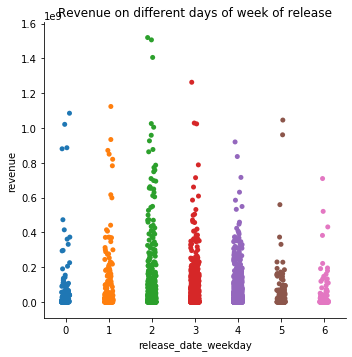

In [17]:
sns.catplot(x='release_date_weekday', y='revenue', data=train);
plt.title('Revenue on different days of week of release');

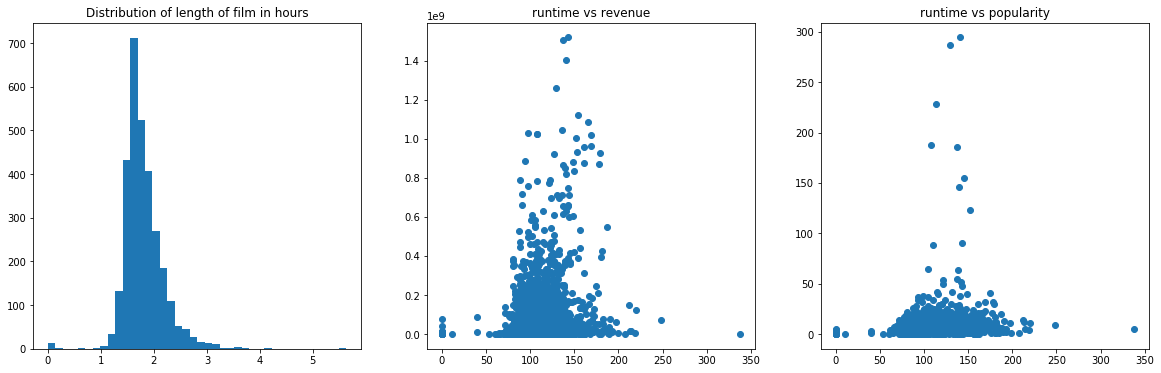

In [18]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.hist(train['runtime']/ 60, bins=40);
plt.title('Distribution of length of film in hours');
plt.subplot(1, 3, 2)
plt.scatter(train['runtime'], train['revenue'])
plt.title('runtime vs revenue');
plt.subplot(1, 3, 3)
plt.scatter(train['runtime'], train['popularity'])
plt.title('runtime vs popularity');

It seems that most of the films are 1.5-2 hour long and films with the highest revenue are also in this range

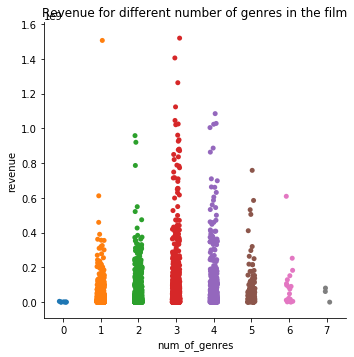

In [19]:
sns.catplot(x='num_of_genres', y='revenue', data=train);
plt.title('Revenue for different number of genres in the film');

In [20]:
sns.set(font_scale=1.5)

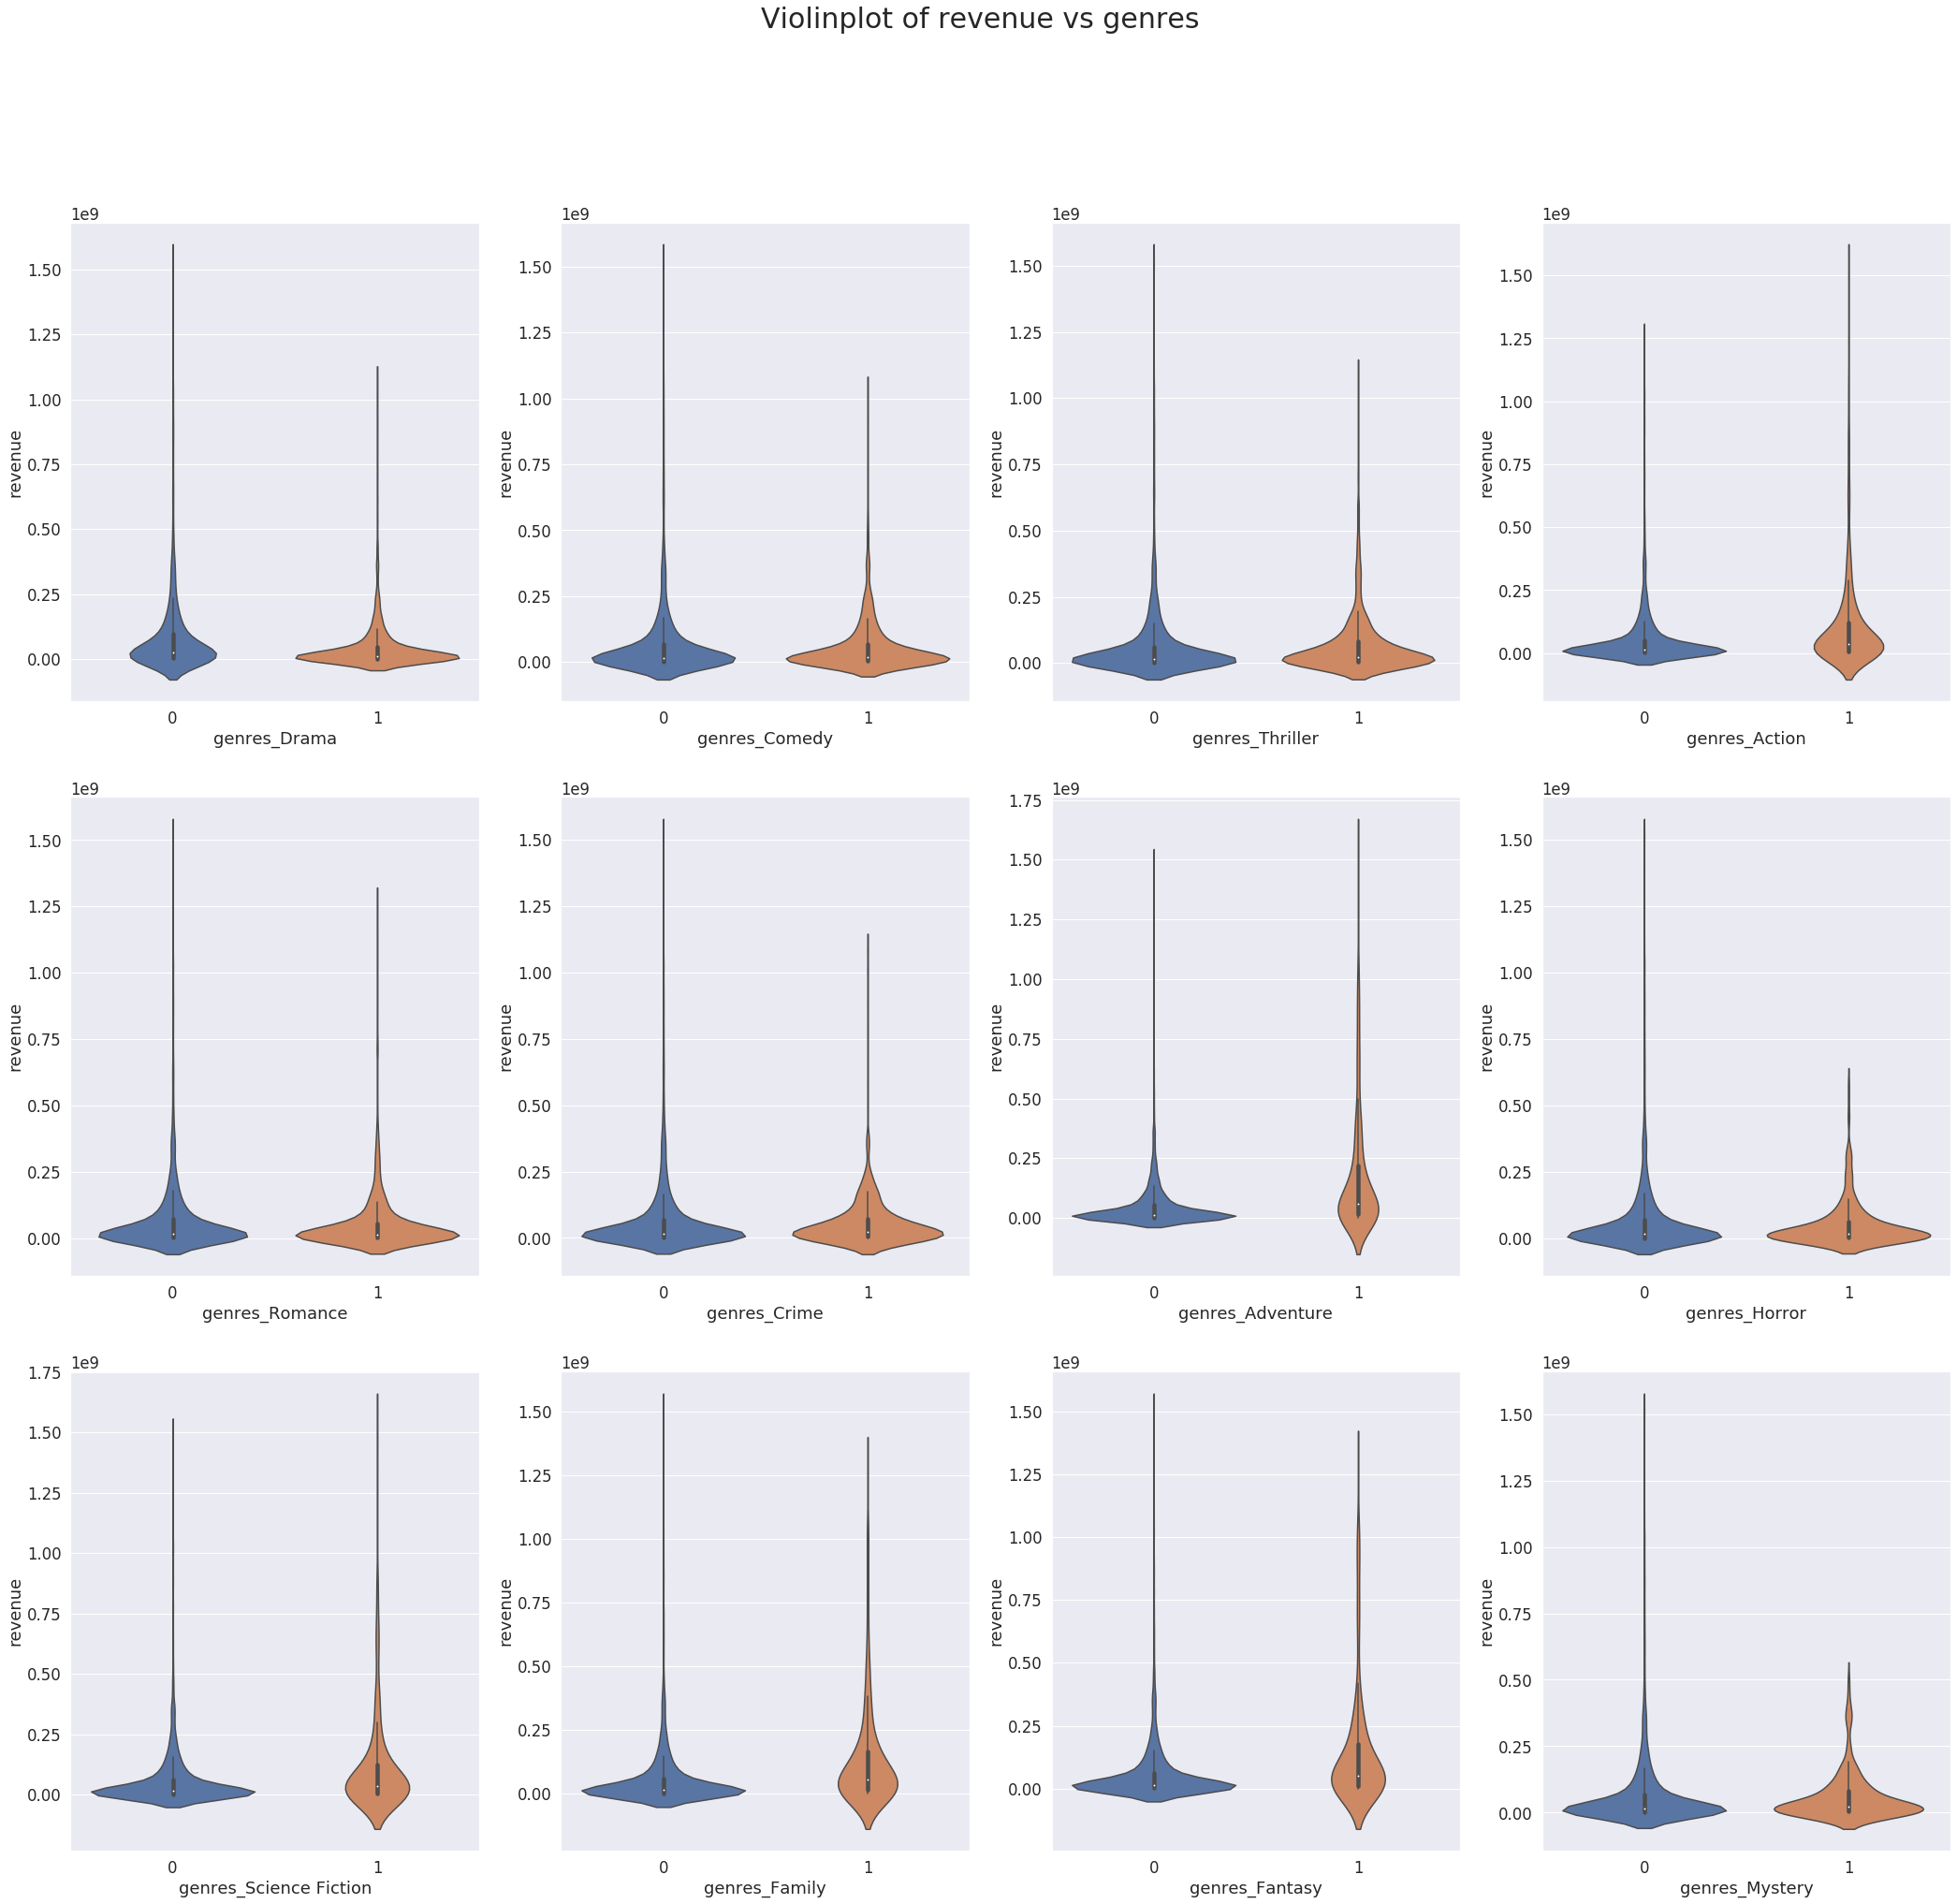

In [21]:
f, axes = plt.subplots(3, 4, figsize=(36, 32))
plt.suptitle('Violinplot of revenue vs genres',fontsize=30.0)
for i, e in enumerate([col for col in train.columns if 'genres_' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 4][i % 4]);

Some genres tend to have less revenue, some tend to have higher.

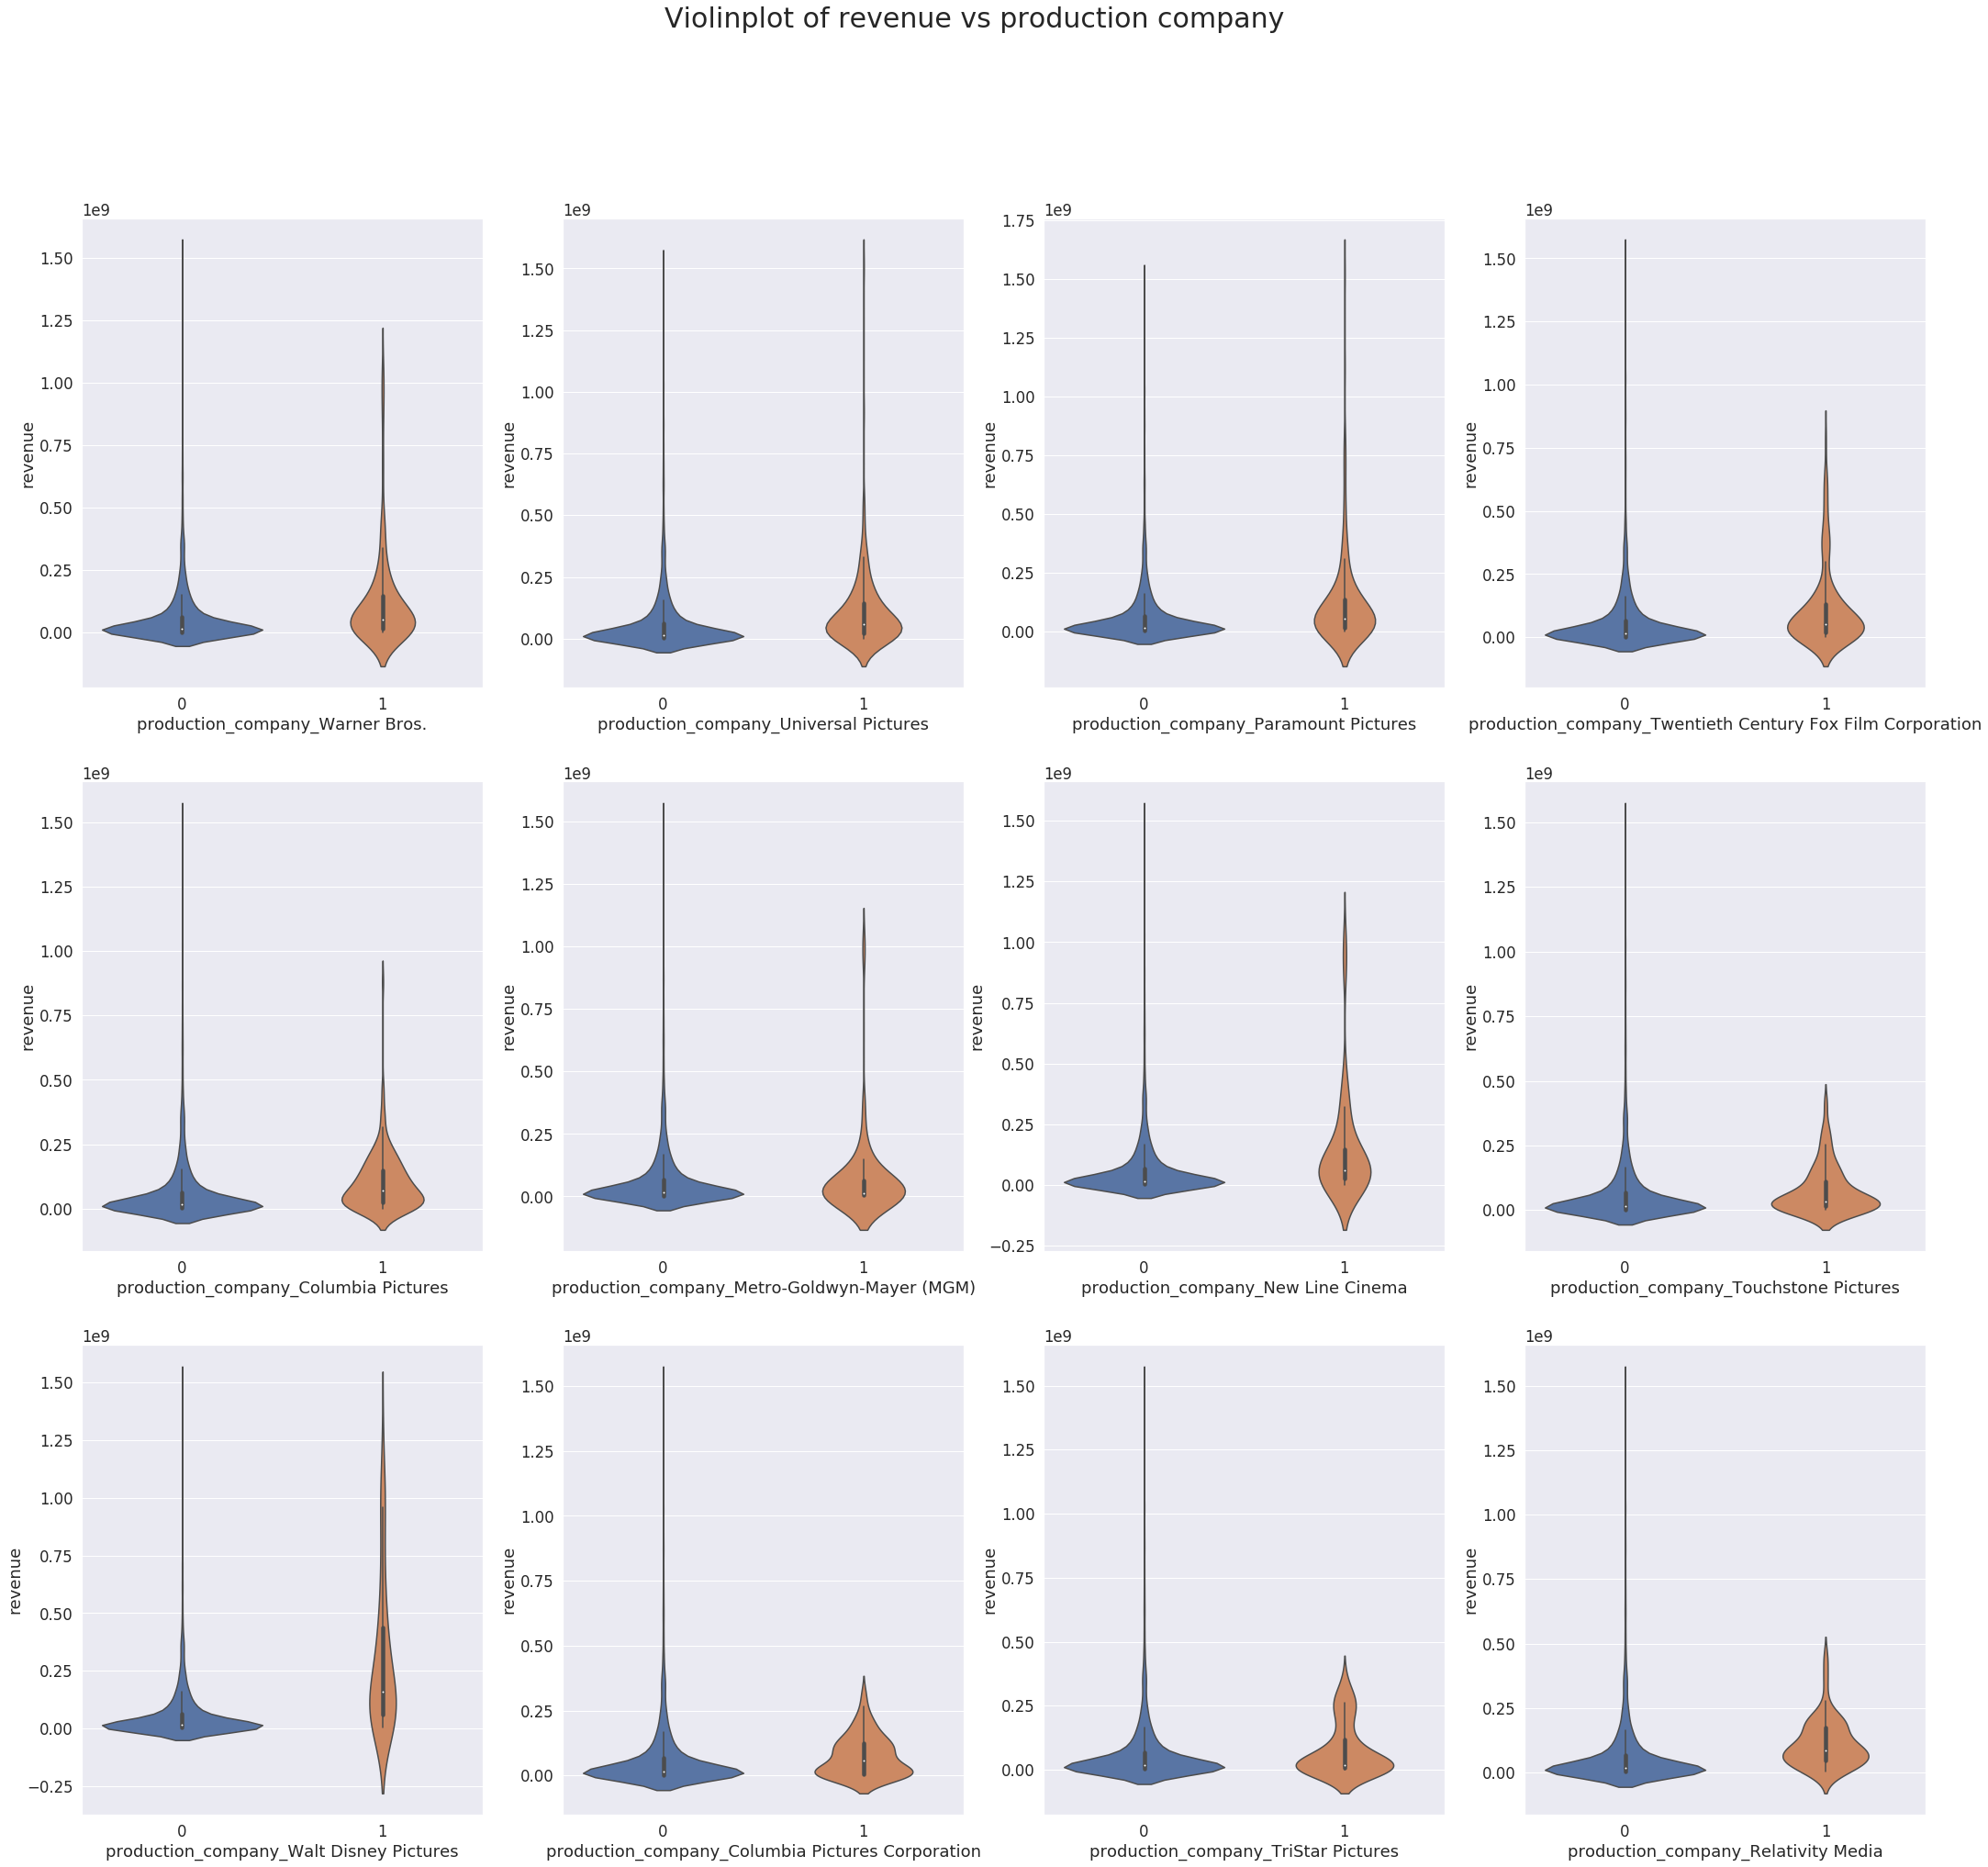

In [22]:
f, axes = plt.subplots(3, 4, figsize=(36, 32))
plt.suptitle('Violinplot of revenue vs production company',fontsize=30.0)
for i, e in enumerate([col for col in train.columns if 'production_company' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 4][i % 4]);

There are only a couple of companies, which have distinctly higher revenues compared to others.

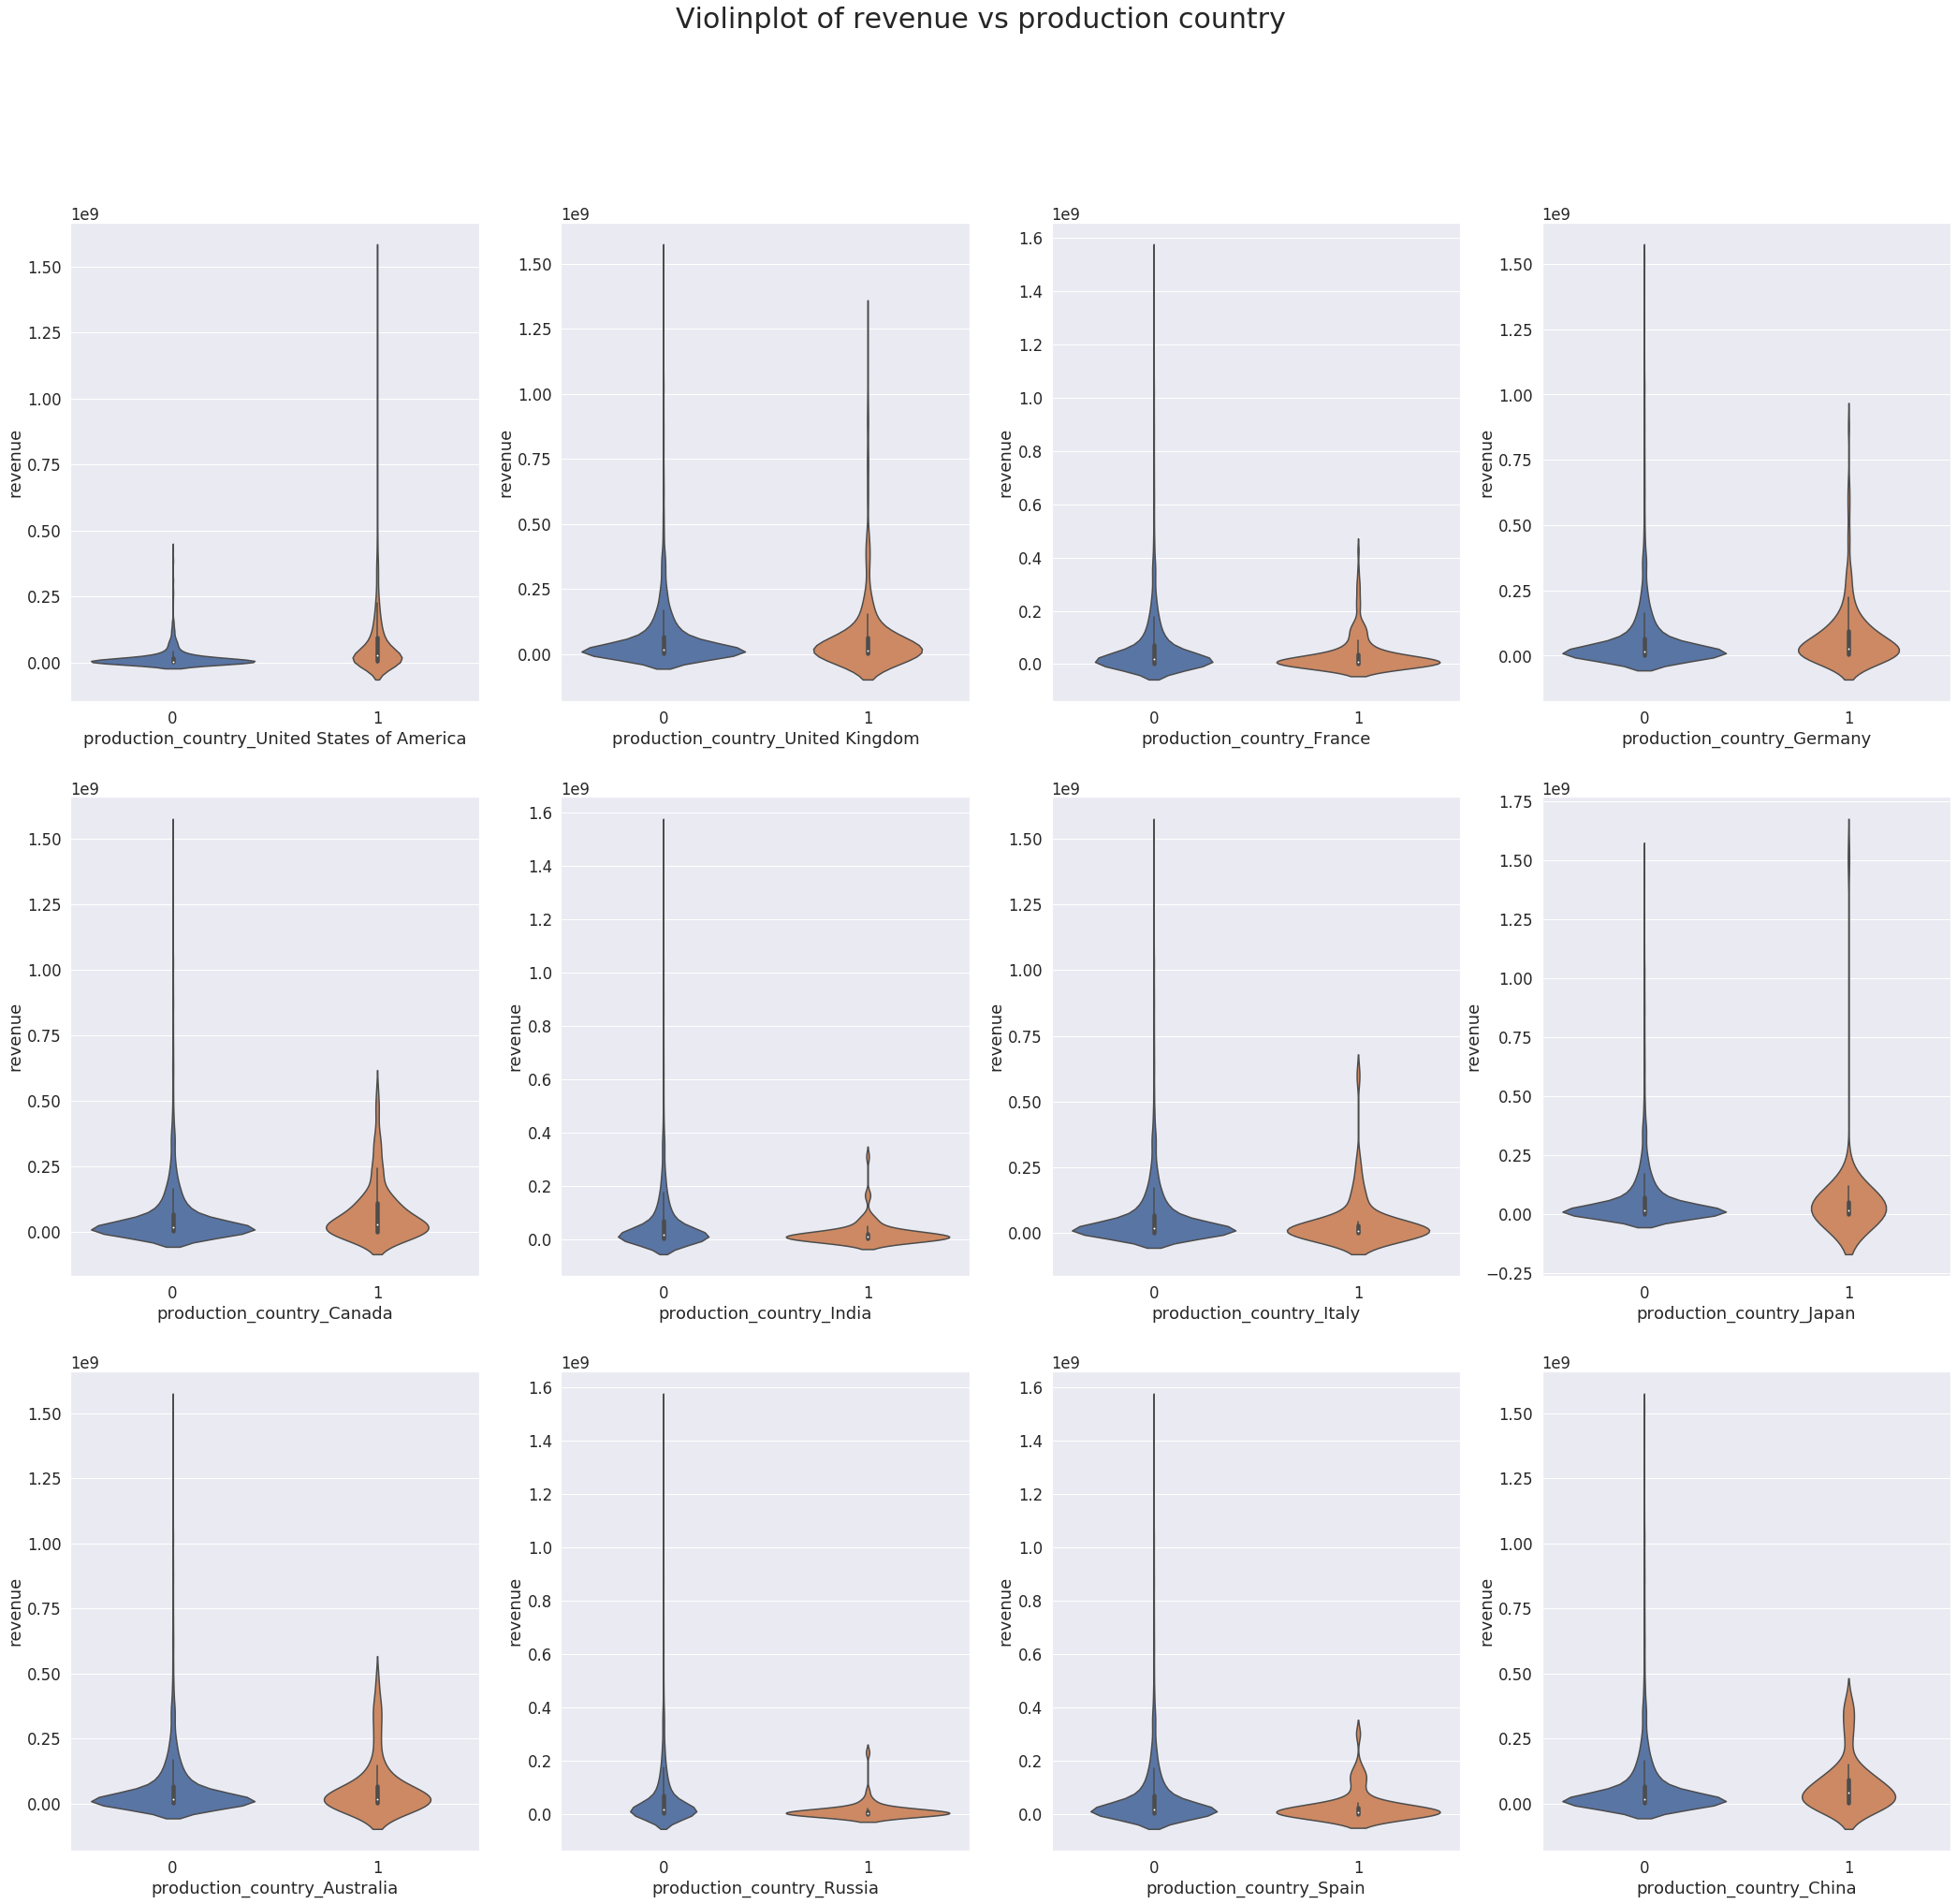

In [23]:
f, axes = plt.subplots(3, 4, figsize=(36, 32))
plt.suptitle('Violinplot of revenue vs production country',fontsize=30.0)
for i, e in enumerate([col for col in train.columns if 'production_country' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 4][i % 4]);

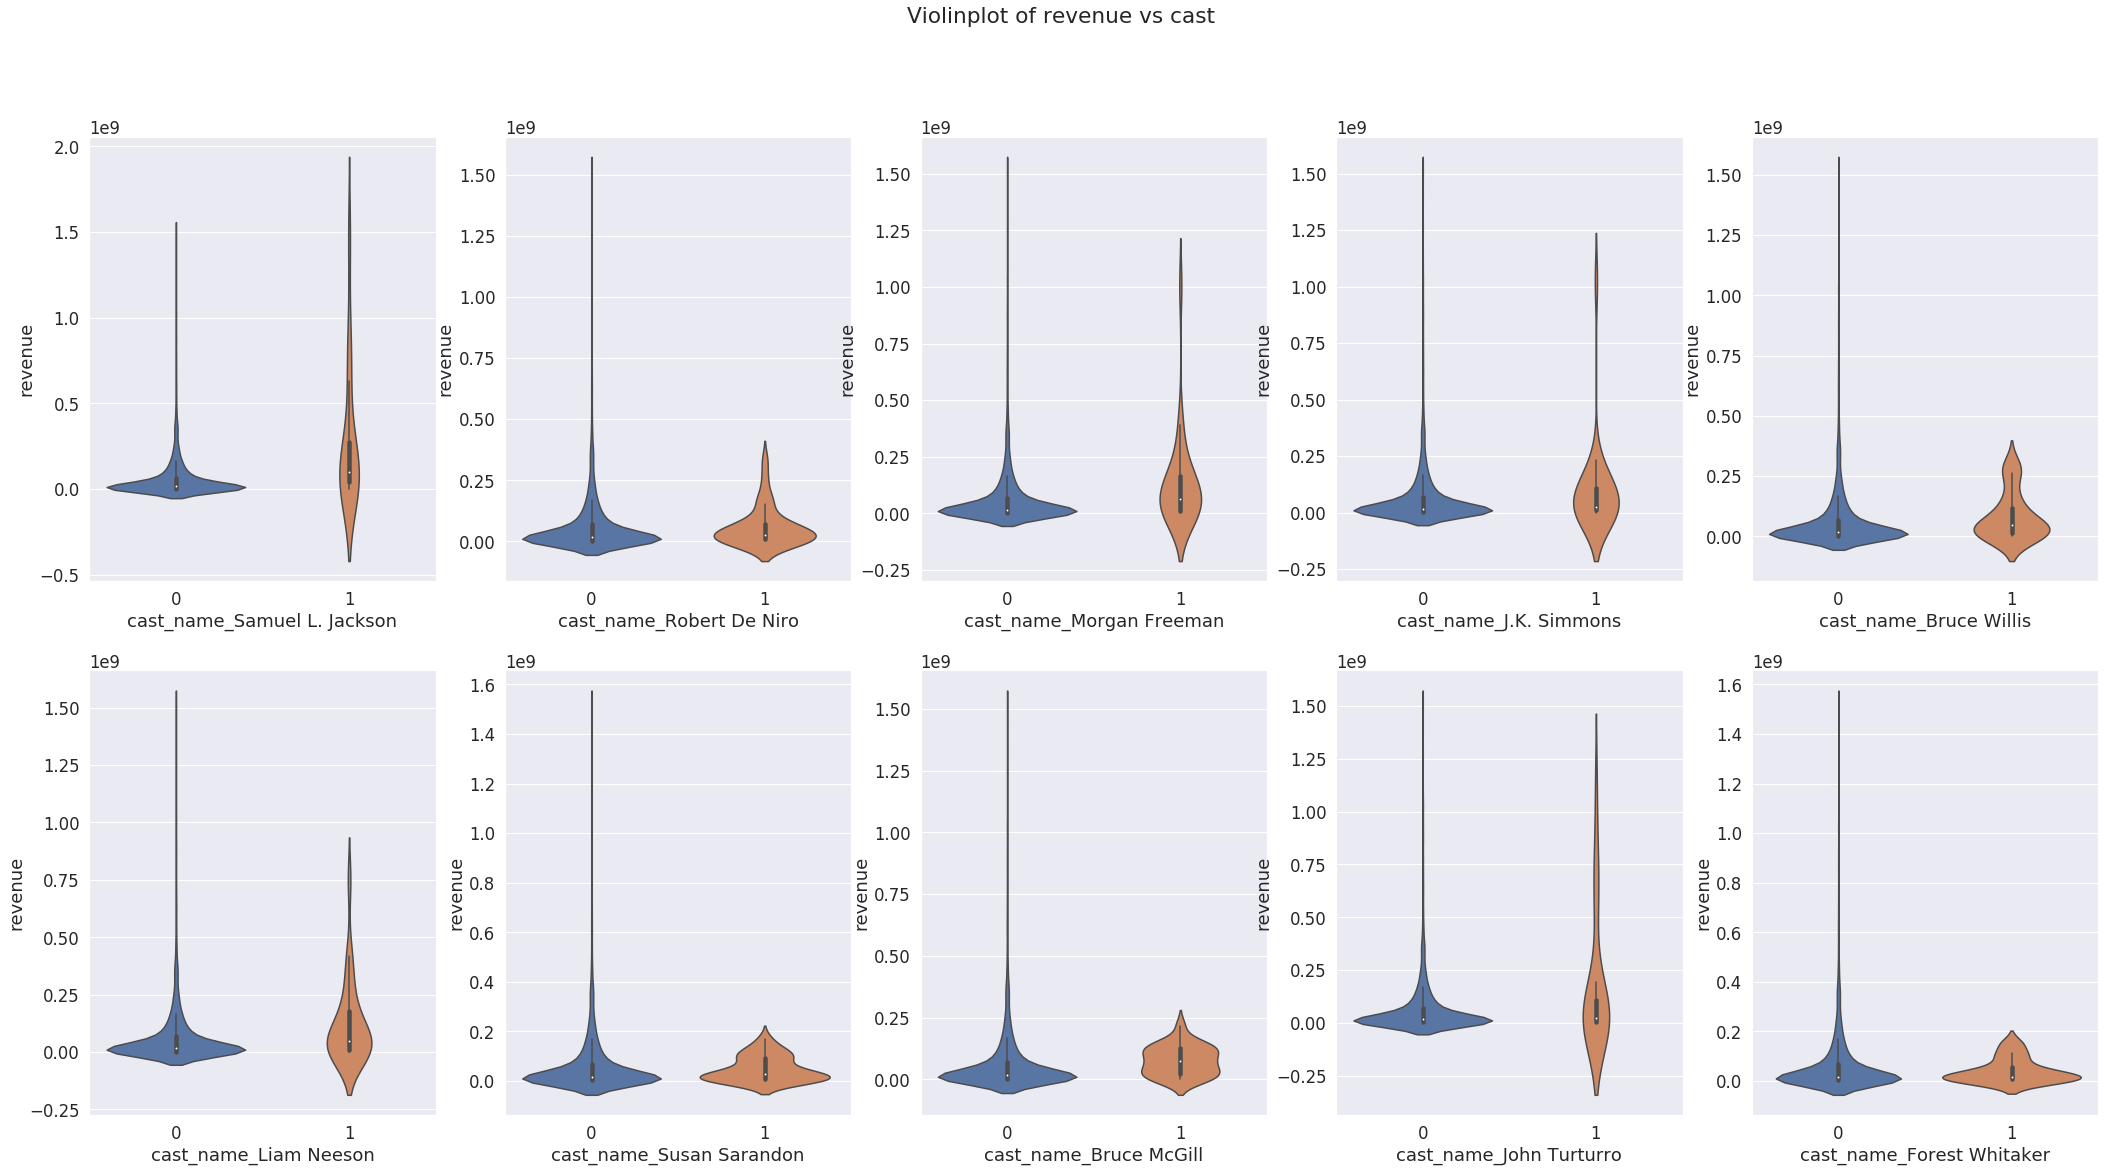

In [24]:
f, axes = plt.subplots(2, 5, figsize=(36, 18))
plt.suptitle('Violinplot of revenue vs cast')
for i, e in enumerate([col for col in train.columns if 'cast_name' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

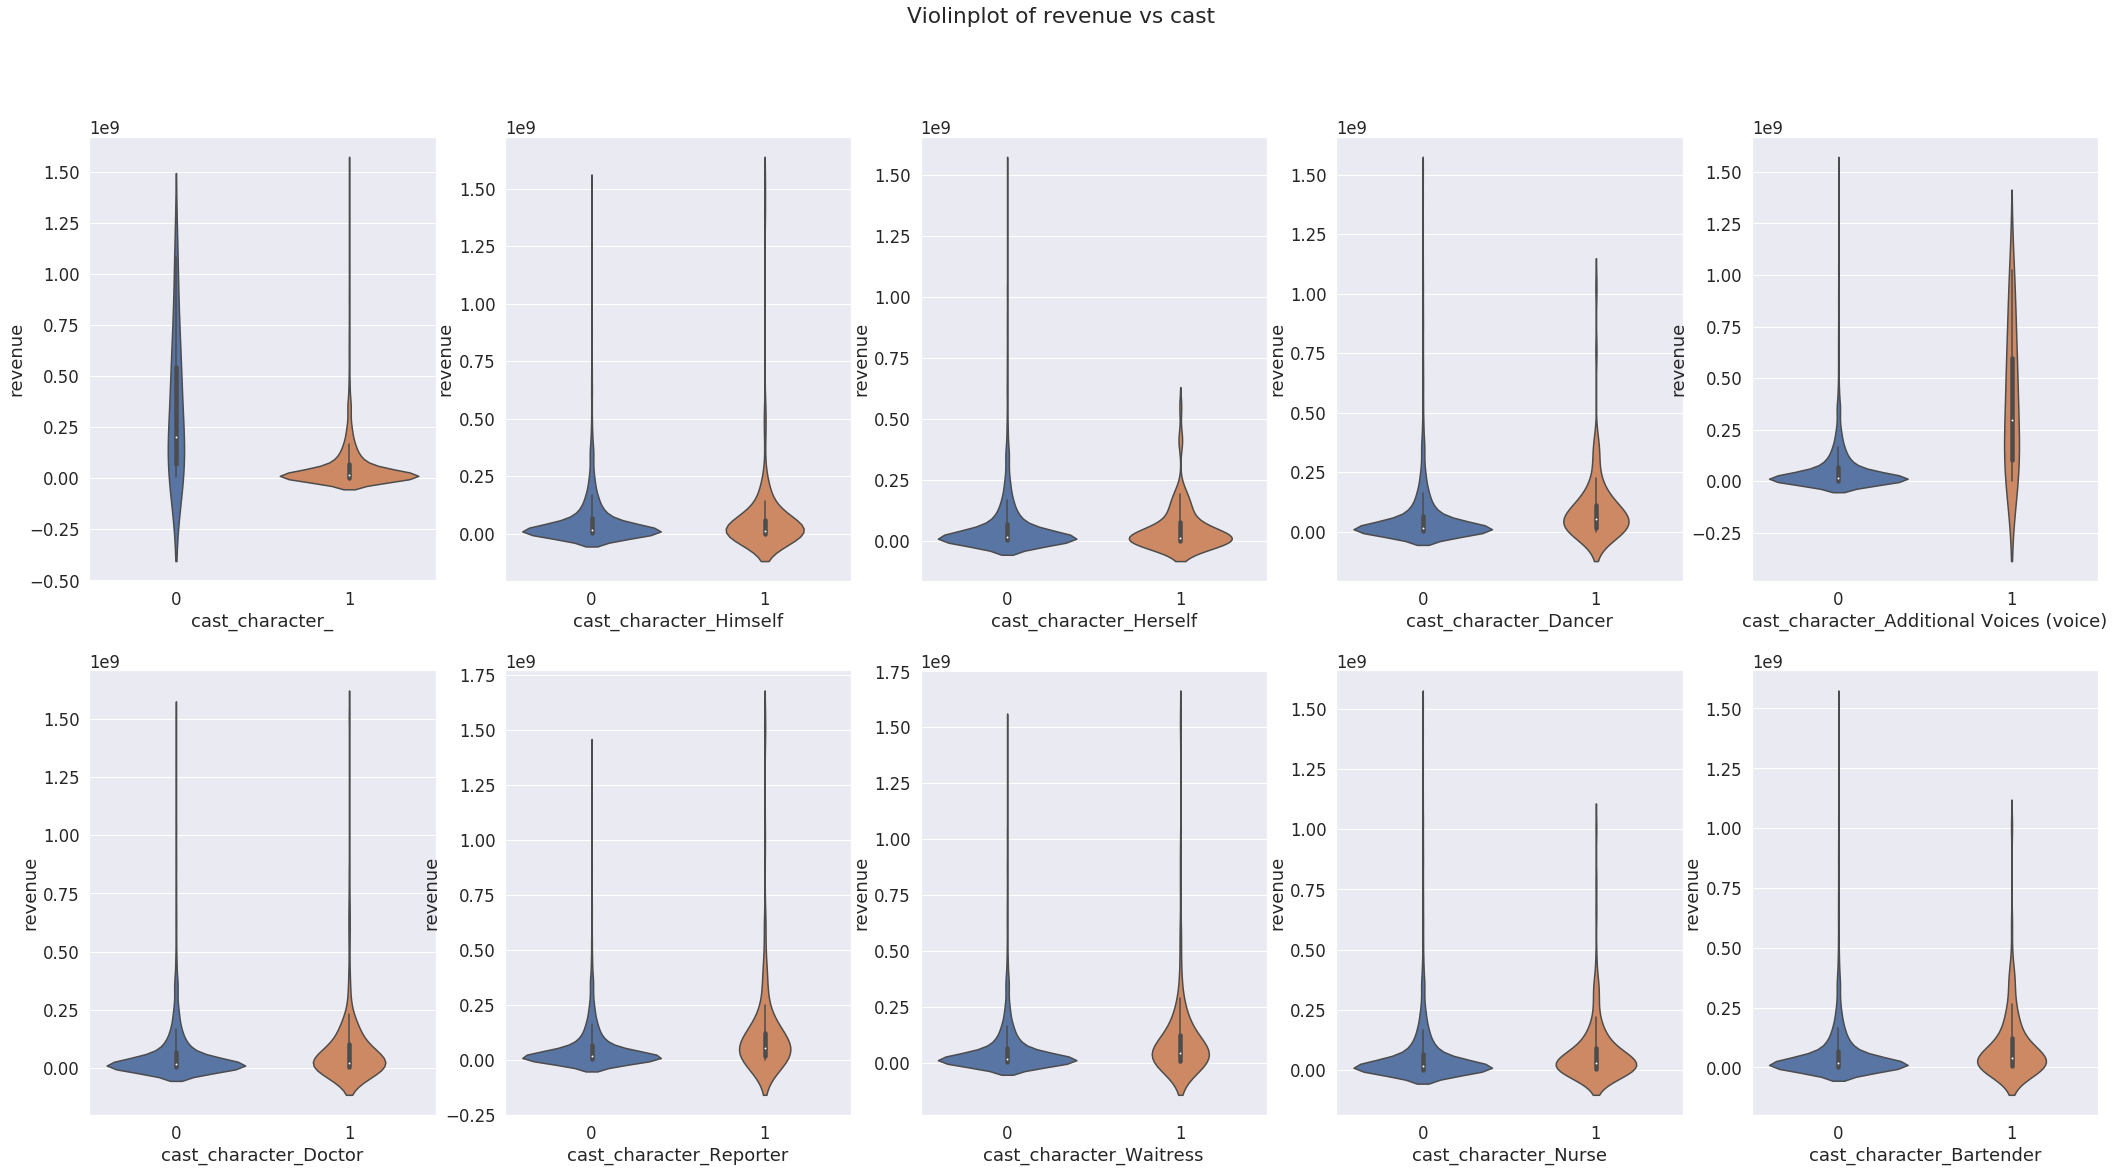

In [25]:
f, axes = plt.subplots(2, 5, figsize=(36, 18))
plt.suptitle('Violinplot of revenue vs cast')
for i, e in enumerate([col for col in train.columns if 'cast_character_' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

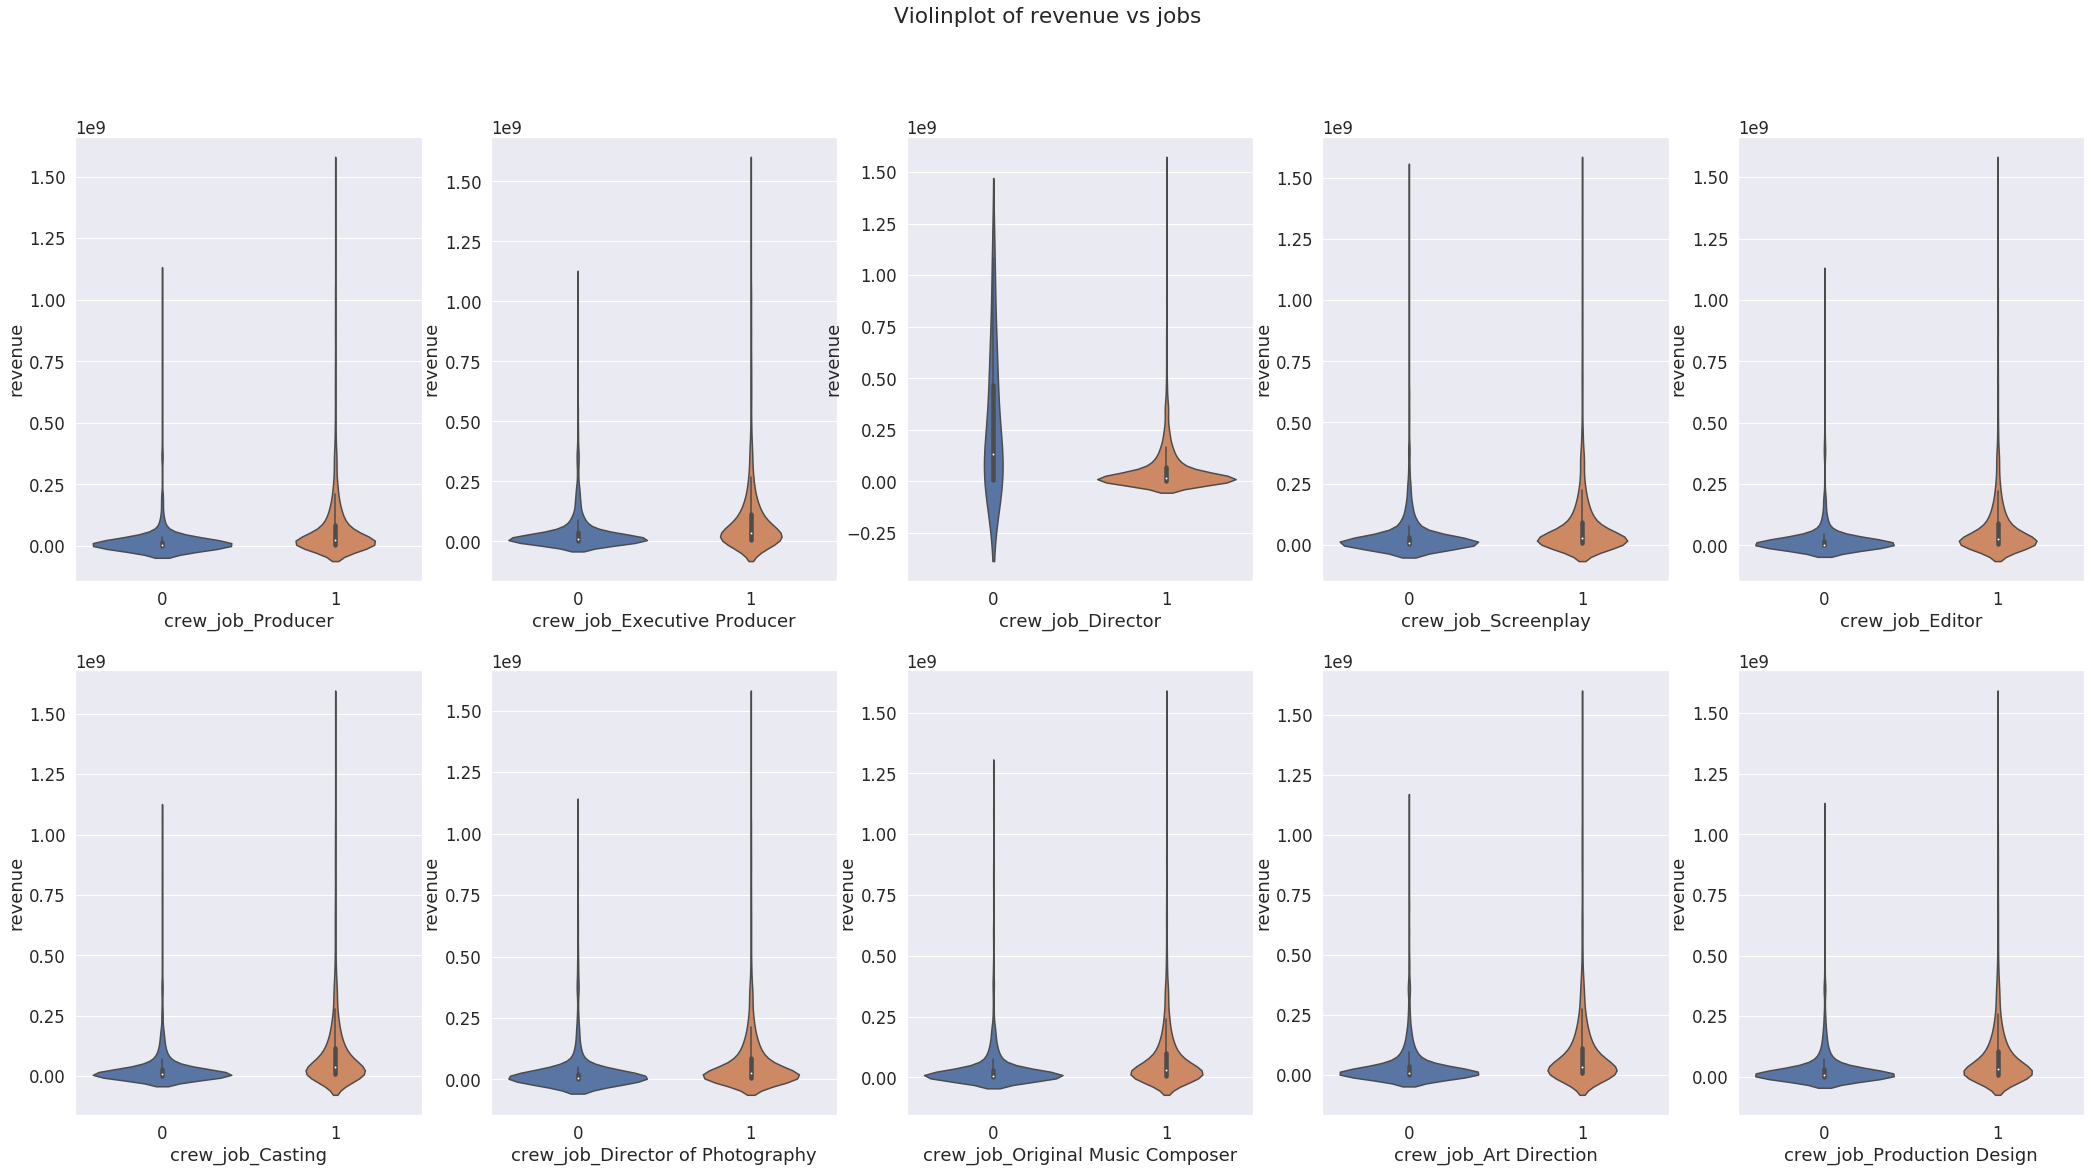

In [26]:
f, axes = plt.subplots(2, 5, figsize=(36, 18))
plt.suptitle('Violinplot of revenue vs jobs')
for i, e in enumerate([col for col in train.columns if 'crew_job_' in col]):
    sns.violinplot(x=e, y='revenue', data=train, ax=axes[i // 5][i % 5]);

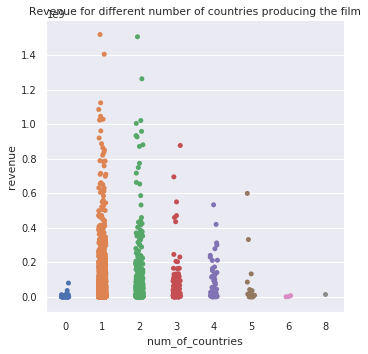

In [27]:
sns.set(font_scale=0.9)
sns.catplot(x='num_of_countries', y='revenue', data=train);
plt.title('Revenue for different number of countries producing the film');

In [28]:
# drop column with only 1 value
for col in train.columns:
    if train[col].nunique() == 1:
        print(col)
        train = train.drop([col], axis=1)
        test = test.drop([col], axis=1)

In [29]:
# Drop some useless column
train=train.drop(['original_title', 'overview','release_date','tagline','title'], axis=1)
test = test.drop(['original_title', 'overview','release_date','tagline','title'], axis=1)

In [30]:
# check null value
train.isnull().any().sum()

0

In [31]:
x_train = train.drop(['id', 'revenue'], axis=1).values
y_train = np.log1p(train['revenue']).values
test_id = test['id']
test = test.drop(['id'], axis=1).values

In [32]:
xg_reg = xgb.XGBRegressor(colsample_bytree = 0.3, learning_rate = 0.001,
                max_depth = 3, alpha = 10, n_estimators = 15000)

In [33]:
xg_reg.fit(x_train,y_train)

[15:56:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.001, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=15000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [34]:
xg_train_pred = xg_reg.predict(x_train)

In [35]:
# xgb train
rmse = np.sqrt(mean_squared_error(y_train, xg_train_pred))
print("RMSE: %f" % (rmse))

RMSE: 1.708814


In [36]:
test_pred = xg_reg.predict(test)
test_pred = np.expm1(test_pred)

In [37]:
# dictionary of lists  
dict = {'id': test_id, 'revenue': test_pred}  
     
df = pd.DataFrame(dict) 
  
# saving the dataframe 
df.to_csv('my_submission_file.csv',index=False) 

## Kaggle Submission Score

RMSE : 2.02076